In [1]:
import sys,os,signal
import os.path

from numpy import *
from stats.transform import spectrogram,standardise
import musicnet

import torch
from torch.autograd import Variable
from torch.nn.functional import conv1d, mse_loss

import matplotlib.pyplot as plt
from IPython.display import Audio
from gc import collect
import h5sparse

from scipy.sparse import lil_matrix
from intervaltree import IntervalTree

from sklearn.metrics import average_precision_score
from sklearn.decomposition import PCA,KernelPCA

from matplotlib.pyplot import *
import plotly.plotly as py
import plotly.graph_objs as go

%matplotlib inline


In [2]:
# os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
# os.environ['CUDA_VISIBLE_DEVICES']='3'

from time import time
from numpy.random import seed

def worker_init(args):
    
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    seed(os.getpid() ^ int(time())) # approximately random seed for workers



fs = 44100

m = 128
k = 500
d = 4096
window = 5*fs
stride = 512
regions = 1 + (window - d)/stride

In [13]:
128/44100

0.0029024943310657597

In [8]:
dataset = musicnet.MusicNet(window=10.0,epoch_size=25)
kwargs = {'num_workers': 6, 'pin_memory': True, 'worker_init_fn': worker_init}
loader = torch.utils.data.DataLoader(dataset=dataset,batch_size=25,**kwargs)

with dataset as data :
    for i, (audio_batch,label_batch) in enumerate(loader):

        audio = concatenate(array(audio_batch),axis=0)
        label = concatenate(array(label_batch),axis=0)

#         time = linspace(0,audio.size,audio.size)/data.sample_frequency
#         figure(figsize=(10,10))

#         for inst in range(11):
#             inst_mask = label[:,inst].astype(bool)

#             if sum(inst_mask) != 0 :
#                 plot(time, audio/amax(audio),'k',alpha=0.01) 
#                 plot(time[inst_mask], audio[inst_mask]/amax(audio),'.',alpha=0.1)

#         xlabel(r'Time, $t$ / s',fontsize=16)
#         ylabel(r'Instrument, $\bar{\mathrm{y}}(t)$',fontsize=16)
#         ylim(-1,1)

# Audio(audio,rate=44100)

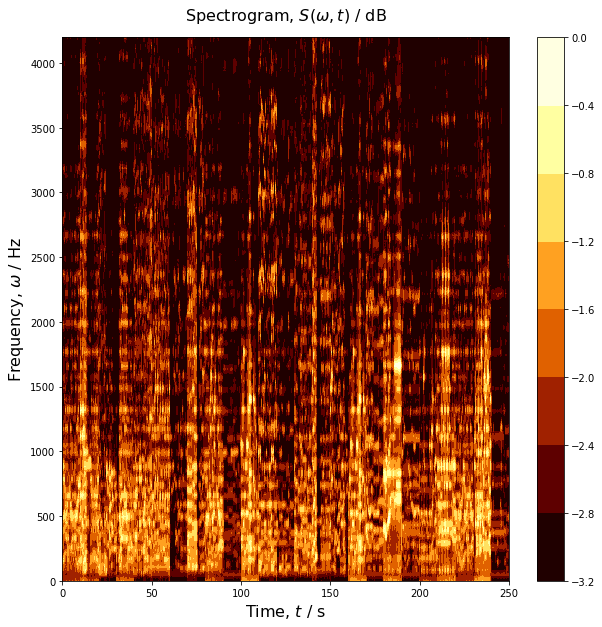

In [9]:
t,f,s = spectrogram(audio, window = 2048, step = 2048/16,thresh=3)

figure(figsize=(10,10))
contourf(t,f,s,cmap='afmhot')

xlabel(r'Time, $t$ / s',fontsize=16)
ylabel(r'Frequency, $\omega$ / $\mathrm{Hz}$',fontsize=16);
title(r'Spectrogram, $S(\omega,t)$ / $\mathrm{dB}$',fontsize=16,y=1.02);
colorbar();

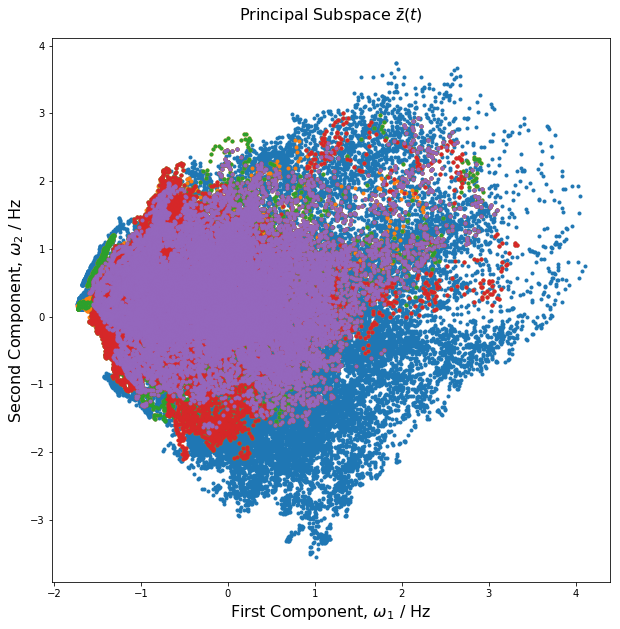

In [10]:
pca = PCA(n_components=2,whiten=True)
pca1,pca2 = pca.fit_transform(s.T).T

figure(figsize=(10,10))
for inst in range(11):
    inst_mask = label[:,inst].astype(bool)[::128]
    
    if sum(inst_mask) != 0 :
        plot(pca1[:][inst_mask], pca2[:][inst_mask],'.',alpha=1)
        
xlabel(r'First Component, $\omega_1$ / $\mathrm{Hz}$',fontsize=16)
ylabel(r'Second Component, $\omega_2$ / $\mathrm{Hz}$',fontsize=16);
title(r'Principal Subspace $\bar\mathrm{z}(t)$',fontsize=16,y=1.02);

In [11]:
def create_filters(d,k,low=50,high=6000):
    x = np.linspace(0, 2*np.pi, d, endpoint=False)
    wsin = np.empty((k,1,d), dtype=np.float32)
    wcos = np.empty((k,1,d), dtype=np.float32)
    start_freq = low
    end_freq = high
    num_cycles = start_freq*d/44000.
    scaling_ind = np.log(end_freq/start_freq)/k
    window_mask = 1.0-1.0*np.cos(x)
    for ind in range(k):
        wsin[ind,0,:] = window_mask*np.sin(np.exp(ind*scaling_ind)*num_cycles*x)
        wcos[ind,0,:] = window_mask*np.cos(np.exp(ind*scaling_ind)*num_cycles*x)
    
    return wsin,wcos

In [ ]:
wsin,wcos = create_filters(d,k)

with torch.cuda.device(0):
    wsin_var = Variable(torch.from_numpy(wsin).cuda(), requires_grad=False)
    wcos_var = Variable(torch.from_numpy(wcos).cuda(), requires_grad=False)
    
def init_weights(scale=0.):
    wscale = 0.
    with torch.cuda.device(0):
        beta = Variable(wscale*torch.rand(regions*k,m).cuda(), requires_grad=True)
        betaavg = Variable(beta.data.clone(), requires_grad=False)
    return (beta,), (betaavg,)

def forward(x, beta):
    zx = conv1d(x[:,None,:], wsin_var, stride=stride).pow(2) \
       + conv1d(x[:,None,:], wcos_var, stride=stride).pow(2)
    return torch.mm(torch.log(zx + musicnet.epsilon).view(x.data.size()[0],regions*k), beta)

def L(y_hat, y, beta):
    # adjust for per-frame loss
    return mse_loss(y_hat, y)*128/2.# + .01*torch.mean(beta.pow(2.))

# Train the model

In [ ]:
weights, averages = init_weights()
loss_history = []
avgp_history = []

In [ ]:
avg = .9998
optimizer = torch.optim.SGD(weights, lr=0.000001, momentum=.95)

try:
    with train_set, test_set:
        print 'square loss\tavg prec\ttime\t\tutime'
        for epoch in range(50):
            t = time()
            for i, (x, y) in enumerate(train_loader):
                optimizer.zero_grad()
                x, y = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                loss = L(forward(x,*weights),y,*weights)
                loss.backward()
                optimizer.step()

                for w,wavg in zip(weights, averages):
                    wavg.copy_(avg*wavg + (1.-avg)*w)

            t1 = time()
            avgp, loss = 0., 0.
            yground = torch.FloatTensor(batch_size*len(test_loader), m)
            yhat = torch.FloatTensor(batch_size*len(test_loader), m)
            for i, (x, y) in enumerate(test_loader):
                x, y = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                yhatvar = forward(x,*averages)
                loss += L(yhatvar,y,*averages).data[0]
                yground[i*batch_size:(i+1)*batch_size,:] = y.data
                yhat[i*batch_size:(i+1)*batch_size,:] = yhatvar.data
            avgp = average_precision_score(yground.numpy().flatten(),yhat.numpy().flatten())
            loss_history.append(loss/len(test_loader))
            avgp_history.append(avgp)
            print '{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(loss_history[-1],avgp_history[-1],time()-t, time()-t1)

except KeyboardInterrupt:
    print 'Graceful Exit'
else:
    print 'Finished'

In [ ]:
burnin = 1

fig = plt.figure(figsize=(15, 7))
fig.add_axes()

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)

for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
    ax.tick_params(direction='out', color='b', width='2')
    
ax1.set_title('square loss')
ax1.plot(np.arange(len(loss_history[burnin:])), loss_history[burnin:])
ax2.set_title('average precision')
ax2.plot(np.arange(len(avgp_history[burnin:])), avgp_history[burnin:])

In [ ]:
def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((int(nw),int(ws)),dtype = a.dtype)

    for i in range(int(nw)):
        # "slide" the window along the samples
        start = int( i * ss )
        stop = int( start + ws )
        out[i] = a[start : stop]

    return out


def stft(X, fftsize=128, step=65, mean_normalize=True, real=False,
         compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)
    
    size = fftsize
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

def pretty_spectrogram(d,fft_size = 2048, step_size = 2048/16, log = True, thresh = 4):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(stft(d, fftsize=fft_size, step=step_size, real=True,
        compute_onesided=True))
  
    if log == True:
        specgram /= specgram.max() # volume normalize to max 1
        specgram = np.log10(specgram) # take log
        specgram[specgram < -thresh] = -thresh # set anything less than the threshold as the threshold
    else:
        specgram[specgram < thresh] = thresh # set anything less than the threshold as the threshold
    
    return specgram